In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/Bump10MSun`


In [51]:
using LaTeXStrings
using Logging
using StatsPlots
using Turing

In [6]:
function cumtrapz(x, y)
    dx = diff(x)
    ymid = 0.5*(y[2:end] .+ y[1:end-1])
    
    dI = dx .* ymid
    vcat(zero(dI[1]), cumsum(dI))
end

cumtrapz (generic function with 1 method)

In [11]:
function make_broken_pl_paired(a1, a2, mb, b)
    mlow = 3.0
    mhigh = 20.0
    
    ms_norm = exp.(log(mlow):0.01:log(mhigh))
    
    function f(m)
        if m < mlow || m > mhigh
            zero(m)
        elseif m < mb
            (m/mb)^a1
        else
            (m/mb)^a2
        end
    end
    
    norm2 = cumtrapz(ms_norm, f.(ms_norm).*ms_norm.^b)
    norm = cumtrapz(ms_norm, f.(ms_norm)./ms_norm.^b.*norm2)[end]
    
    function pm1m2(m1, m2)
        f(m1)*f(m2)*(m2/m1)^b/norm
    end
    pm1m2
end

make_broken_pl_paired (generic function with 1 method)

In [44]:
@model function mass_model(pm1m2)
    m1 ~ Uniform(3, 20)
    m2_frac ~ Uniform(0, 1)

    m2 = 3 + m2_frac*(m1-3)
    Turing.@addlogprob! log(m1-3)
    
    
    Turing.@addlogprob! log(pm1m2(m1, m2))
    
    return (m2 = m2, )
end

mass_model (generic function with 1 method)

In [65]:
pm1m2 = make_broken_pl_paired(2.0, -2.0, 10.0, 0.0)
model = mass_model(pm1m2)
trace = sample(model, NUTS(), 10000)
genq = with_logger(NullLogger()) do
    generated_quantities(model, trace)
end;

┌ Info: Found initial step size
│   ϵ = 1.6500000000000001
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/wfarr/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/wfarr/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/wfarr/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/wfarr/.julia/packages/AdvancedH

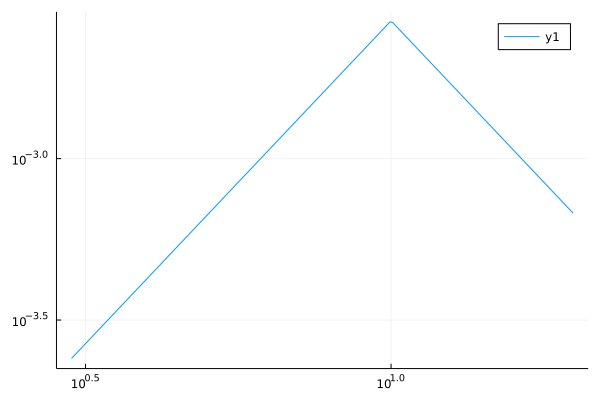

In [66]:
ms = exp.(log(3.0):0.01:log(20.0))
plot(ms, pm1m2.(ms, 3.0), yscale=:log10, xscale=:log10)

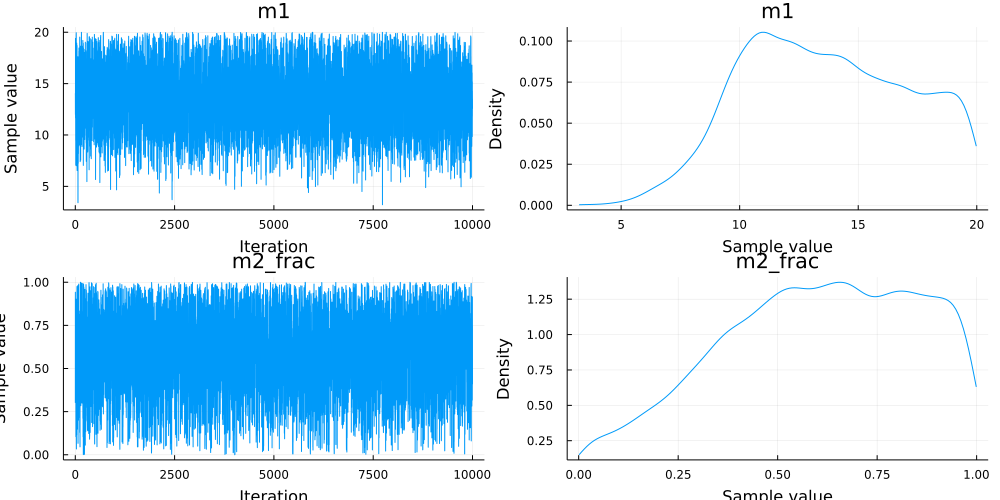

In [67]:
plot(trace)

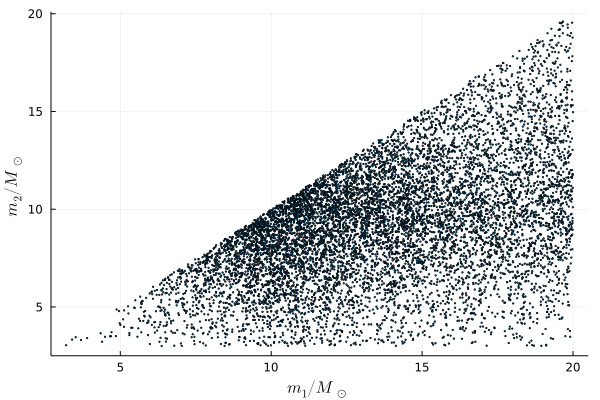

In [68]:
scatter(trace[:m1], [x.m2 for x in genq], legend=nothing, xlabel=L"m_1 / M_\odot", ylabel=L"m_2 / M_\odot", markersize=1)

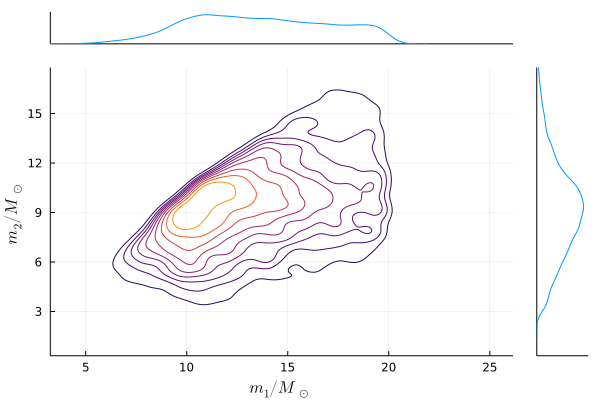

In [69]:
marginalkde(trace[:m1], [x.m2 for x in genq], legend=nothing, xlabel=L"m_1 / M_\odot", ylabel=L"m_2 / M_\odot")

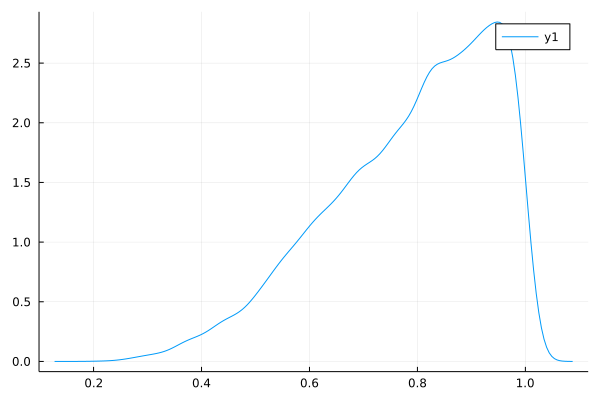

In [63]:
density([x.m2 for x in genq] ./ trace[:m1])